## Linear Regression 2


This notebook implement linear regression using Gradient Descent for linear regression in 2 different ways: 
* closed form solution 
* iterative solution using stochastic and batch versions of gradient desceent 

We'll use the diabetes prediction dataset for our task.


# Data Splits
[Paper](https://tibshirani.su.domains/ftp/lars.pdf): Efron et al. (2004): “Least Angle Regression,” Annals of Statistics (with discussion), 407–499.

[Data description](https://www4.stat.ncsu.edu/~boos/var.select/diabetes.html): 10 baseline variables (age, sex, body mass index, average blood pressure, and six blood serum measurements) and the response of interest (a quantitative measure of disease progression one year after baseline readings) for n = 442 diabetes patients.

In [ ]:
# standard libraries
import pandas as pd
import numpy as np
import os

# ML - Sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

# visualizations
import matplotlib.pyplot as plt
from IPython.display import Image
%matplotlib inline

In [ ]:
# Load data 
df = pd.read_csv(
    'https://www4.stat.ncsu.edu/~boos/var.select/diabetes.tab.txt',
    delimiter='\t'
)

df.head(5)

,AGE,SEX,BMI,BP,S1,S2,S3,S4,S5,S6,Y
0,59,2,32.1,101.0,157,93.2,38.0,4.0,4.8598,87,151
1,48,1,21.6,87.0,183,103.2,70.0,3.0,3.8918,69,75
2,72,2,30.5,93.0,156,93.6,41.0,4.0,4.6728,85,141
3,24,1,25.3,84.0,198,131.4,40.0,5.0,4.8903,89,206
4,50,1,23.0,101.0,192,125.4,52.0,4.0,4.2905,80,135


In [ ]:
# rename columns for interpretability
df.columns = [
    'age', 'sex', 'bmi', 'map',
    'tc', 'ldl', 'hdl', 'tch',
    'ltg', 'glu', 'disease_progression']

df.head(5)

,age,sex,bmi,map,tc,ldl,hdl,tch,ltg,glu,disease_progression
0,59,2,32.1,101.0,157,93.2,38.0,4.0,4.8598,87,151
1,48,1,21.6,87.0,183,103.2,70.0,3.0,3.8918,69,75
2,72,2,30.5,93.0,156,93.6,41.0,4.0,4.6728,85,141
3,24,1,25.3,84.0,198,131.4,40.0,5.0,4.8903,89,206
4,50,1,23.0,101.0,192,125.4,52.0,4.0,4.2905,80,135


In [ ]:
# Train/Test Splits 

y = df['disease_progression'].values

# define features #
###################
X = df[['age', 'sex', 'bmi', 'map', 'tc', 'ldl', 'hdl', 'tch', 'ltg', 'glu']].values

# split #
#########
split = (0.7,0.3) #70% training and 30% test - equivalent to the df.sample() function in pandas  
shuffle = np.random.permutation(np.arange(y.shape[0])) # very important to shuffle the data. Why?
X, y = X[shuffle], y[shuffle]

splits = np.multiply(len(y), split).astype(int) 
X_train, X_test = np.split(X, [splits[0]])
y_train, y_test = np.split(y, [splits[0]])


# Put them back into a dataframe df_train  -- we'll use df_train only for EDA, not training/testing. 
##############################
# easier for EDA later on
df_train = pd.concat(
    [pd.DataFrame(y_train), pd.DataFrame(X_train)],
    axis=1
)

# rename columns
df_train.columns=['disease_progression', 'age', 'sex', 'bmi', 'map',
    'tc', 'ldl', 'hdl', 'tch',
    'ltg', 'glu']

df_train

,disease_progression,age,sex,bmi,map,tc,ldl,hdl,tch,ltg,glu
0,77,59.0,2.0,24.7,114.0,152.0,104.8,29.0,5.0,4.5109,88.0
1,91,64.0,2.0,23.5,97.0,203.0,129.0,59.0,3.0,4.3175,77.0
2,214,61.0,1.0,24.6,101.0,209.0,106.8,77.0,3.0,4.8363,88.0
3,123,44.0,2.0,26.6,99.0,205.0,109.0,43.0,5.0,5.5797,111.0
4,150,64.0,2.0,27.3,109.0,186.0,107.6,38.0,5.0,5.3083,99.0
...,...,...,...,...,...,...,...,...,...,...,...
304,220,53.0,2.0,27.7,95.0,190.0,101.8,41.0,5.0,5.4638,101.0
305,132,62.0,1.0,32.0,88.0,172.0,69.0,38.0,4.0,5.7838,100.0
306,42,46.0,2.0,23.5,87.0,181.0,114.8,44.0,4.0,4.7095,98.0
307,75,67.0,2.0,22.5,98.0,191.0,119.2,61.0,3.0,3.9890,86.0


## Feature scaling can be done in two ways 

**normalization**: rescaling of the features to a range of [0,1]. Also called min-max scaling. Mostly used when we need values in a bounded interval (you can do this manually, but you can also use the MinMaxScaler() method that you can find in sklearn.preprocessing module).

**standardization**: center the feature columns at mean 0 and std 1. Prefered over normalization, as it preservers useful information about outliers and makes the algorithm less sensitive to them. This is used below.

In [ ]:
# standardize
sc_x = StandardScaler()
sc_y = StandardScaler()
X_train_std = sc_x.fit(X_train).transform(X_train)
X_test_std = sc_x.fit(X_train).transform(X_test)

y_train_std = sc_y.fit(np.expand_dims(y_train, axis=1)).transform(np.expand_dims(y_train, axis=1)).flatten()
y_test_std = sc_y.fit(np.expand_dims(y_train, axis=1)).transform(np.expand_dims(y_test, axis=1)).flatten()

Note how we fit the StandardScaler() only on the training data, and use the mean and sd parameters to transform the test data!

## EDA 
Prior to training a model it is important to perform exploratory data analysis. The idea is to detect any missing data, the presence of outliers, the feature distribution, and the relationship between features and outcome. Note that typically there is a back and forth between Step 4 and 5, depending on how satisfied you are with the results of the EDA.

In [ ]:
# check for missing values; impute if needed which is not the case here.
df_train.isna().sum()

disease_progression    0
age                    0
sex                    0
bmi                    0
map                    0
tc                     0
ldl                    0
hdl                    0
tch                    0
ltg                    0
glu                    0
dtype: int64

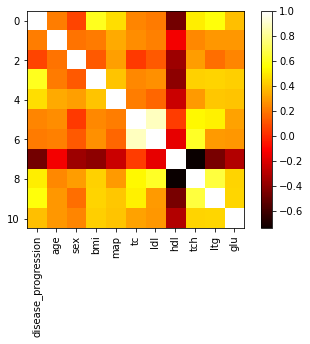

In [ ]:
# correlation matrix of outcome and feature variables
corr = df_train.corr().values

plt.imshow(corr, cmap='hot', interpolation='nearest')
ax = plt.gca() #get currant axes function
x_label_list = ['disease_progression', 'age', 'sex', 'bmi', 'map','tc', 'ldl', 'hdl', 'tch','ltg', 'glu']
ax.set_xticklabels (x_label_list, rotation=90)
ax.set_xticks(np.arange(len(x_label_list)))
plt.colorbar()

plt.show()

<span style="color:chocolate"> *Question:*</span> Which features seem to be most informative to predict diabetes progression?

Answer: The most highly correlated ones.

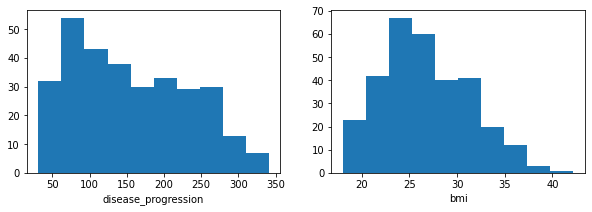

In [ ]:
#histgrams of features and labels 

columns = ['disease_progression', 'bmi']

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,3))
for idx, ax in enumerate(axes.flatten()):
    # plot histogram
    ax.hist(df_train[columns[idx]])
    # set xlabel
    ax.set_xlabel(columns[idx])

## Linear Regression with one variable
We will begin with a single-variable linear regression to predict 'disease_progression' from 'bmi'.

The idea behind linear regression is to obtain the best-fitting straight line through the examples in the training data.

There are two ways you can fit the training data:
 - using a closed-form solution: $ W = (X'X)^{-1}(X'y)$
 - using an iterative solution: gradient descent (stochastic, batch)

In [ ]:
# define features of interest
temp_X_train_std = X_train_std[:,2] # choose only BMI
temp_X_test_std = X_test_std[:,2]
print (temp_X_train_std.shape)

# expand dimension so that temp_X_train_std is a 2D array
temp_X_train_std = np.expand_dims(temp_X_train_std, axis=1) 
print (temp_X_train_std.shape)
temp_X_test_std = np.expand_dims(temp_X_test_std, axis=1) 

# define shape of temp_X_train_std
temp_shape_X_train_std = temp_X_train_std.shape[1]

(309,)
(309, 1)


### Linear Regression - Closed Form Solution



In [ ]:
# CLOSED FORM SOLUTION
from numpy import linalg 

a  = linalg.pinv(np.dot (temp_X_train_std.T, temp_X_train_std))
b = np.dot (temp_X_train_std.T,y_train_std)
w = np.dot(a,b)

predictions_closed_form = np.dot (temp_X_train_std, w)
#print (predictions_closed_form)

print ("MSE (closed form): ", mean_squared_error( predictions_closed_form, y_train_std))


MSE (closed form):  0.6262119980141617


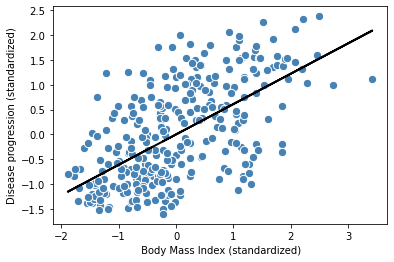

In [ ]:
plt.scatter(temp_X_train_std, y_train_std, c='steelblue', edgecolor='white', s=70)
plt.plot(temp_X_train_std, predictions_closed_form, color='black', lw=2)    

plt.xlabel(' Body Mass Index (standardized)')
plt.ylabel('Disease progression (standardized)')
plt.show()

### Linear Regression -- Batch Gradient Descent (from scratch)

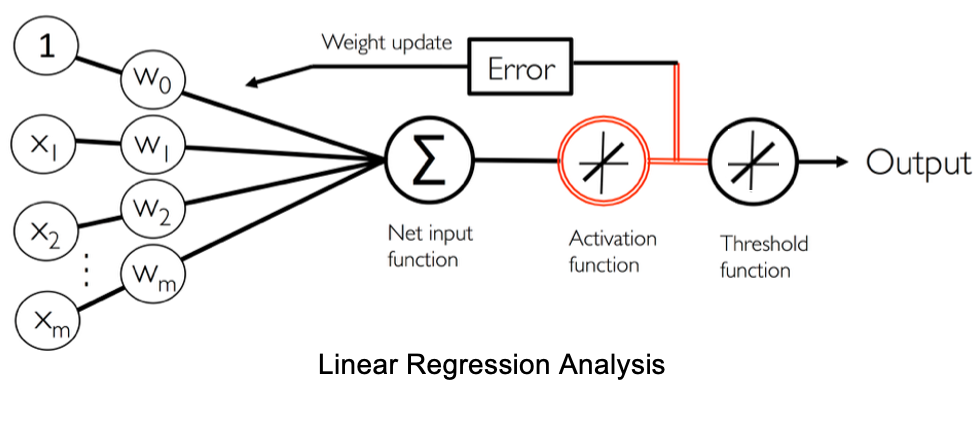

In [ ]:
Image(filename='linear.png', width=600)

Let j represent features, j = [1,...,m]

Let i represent observations, i = [1, ..., n]


``Net input function``:

z = $w_{0} \cdot 1 + w_{1} \cdot x_{1} + w_{2} \cdot x_{2} + ... + w_{m} \cdot x_{m}$

``Linear activation function``:

$\phi(z)= w_{0} \cdot 1 + w_{1} \cdot x_{1} + w_{2} \cdot x_{2} + ... + w_{m} \cdot x_{m}$


`` Compute error``:

$(y\_actual_{i} - \phi(z_{i}))$, , where $\phi(z_{i})$ is $y\_pred_{i}$

``Update weights``:

$w_{j} := w_{j} + \Delta w_{j}, \forall j \in {1,...,m}$

$\Delta w_{j} = \eta \sum _{i}(y\_actual_{i} - \phi(z_{i}))\cdot x_{i,j}, \forall j \in {1,...,m}, \forall i \in {1,...,n}$


``Threshold function``:

$\tau(z) = w_{0} \cdot 1 + w_{1} \cdot x_{1} + w_{2} \cdot x_{2} + ... + w_{m} \cdot x_{m}$


`` Note on Batch Gradient Descent``:

The weights are updated using **all training examples** (see the summation operator in the equation $\Delta w_{j}$)

In [ ]:
# BATCH GRADIENT DESCENT

# Step 1: initalize hyperparameters
eta = 0.1 # learning rate 
n_iter = 10
random_state = 1

# Step 2: initalize weights (to small random numbers)
rgen = np.random.RandomState(random_state)
w_ = rgen.normal(loc=0.0, scale=0.01, size=1 + temp_shape_X_train_std)

# Step 3: initialize cost lists
cost_ = []

# Step 4: compute net input, linear activation function, update weights, track cost
def fit(X, y):
    for iter_ in range(n_iter):
        # compute the net input function
        net_input = np.dot(X, w_[1:]) + w_[0]

        # compute the linear activation function; this gives us y_pred
        temp_y_pred = net_input
        
        # compute error
        errors = (y - temp_y_pred)
        #print(y, temp_y_pred)

        # update weights (notice how weights are updated using all training examples!)
        w_[1:] += eta * X.T.dot(errors)
        w_[0] += eta * errors.sum()

        # compute cost (we find weights by minimizing costs; in the Linear model the cost is SSE/2)
        cost = (errors**2).sum()/2.0  
        cost_.append(cost)
        
    return cost_

# Step 5: compute the threshold (linear) function
def predict(X):
    net_input = np.dot(X, w_[1:]) + w_[0]
    
    # threshold function
    y_pred = net_input
    
    return y_pred

Model fit and prediction

CPU times: user 725 µs, sys: 0 ns, total: 725 µs
Wall time: 755 µs


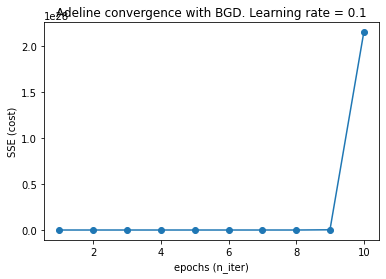

In [ ]:
%time cost_ = fit(temp_X_train_std, y_train_std)
y_train_std_pred = predict(temp_X_train_std)

# plot cost # need to rescale SSE 
plt.plot((range(1, len(cost_) + 1)), cost_, marker='o');
plt.xlabel('epochs (n_iter)');
plt.ylabel('SSE (cost)'); # number of times y_actual != y_pred 

plt.title('Adeline convergence with BGD. Learning rate = ' + str(eta));

Evaluation

In [ ]:
print('MSE:', mean_squared_error(y_train_std, y_train_std_pred))

MSE: 1.2445075890118197e+29


<span style="color:chocolate"> *Exercise:*</span> 

Try increasing the number of iterations and see what happens.

Then see what happens if you change the learning rate.

If the learning rate is too large (set eta = 0.02): instead of minimizing the cost function, the error become larger after each epoch. This happens because we overshoot the global minimum.

If the learning rate is too small (set eta = 0.0001): the cost decreases but the learning rate is so small that the algo requires lots of epochs to converge (this can be very computational expensive with large datasets!)

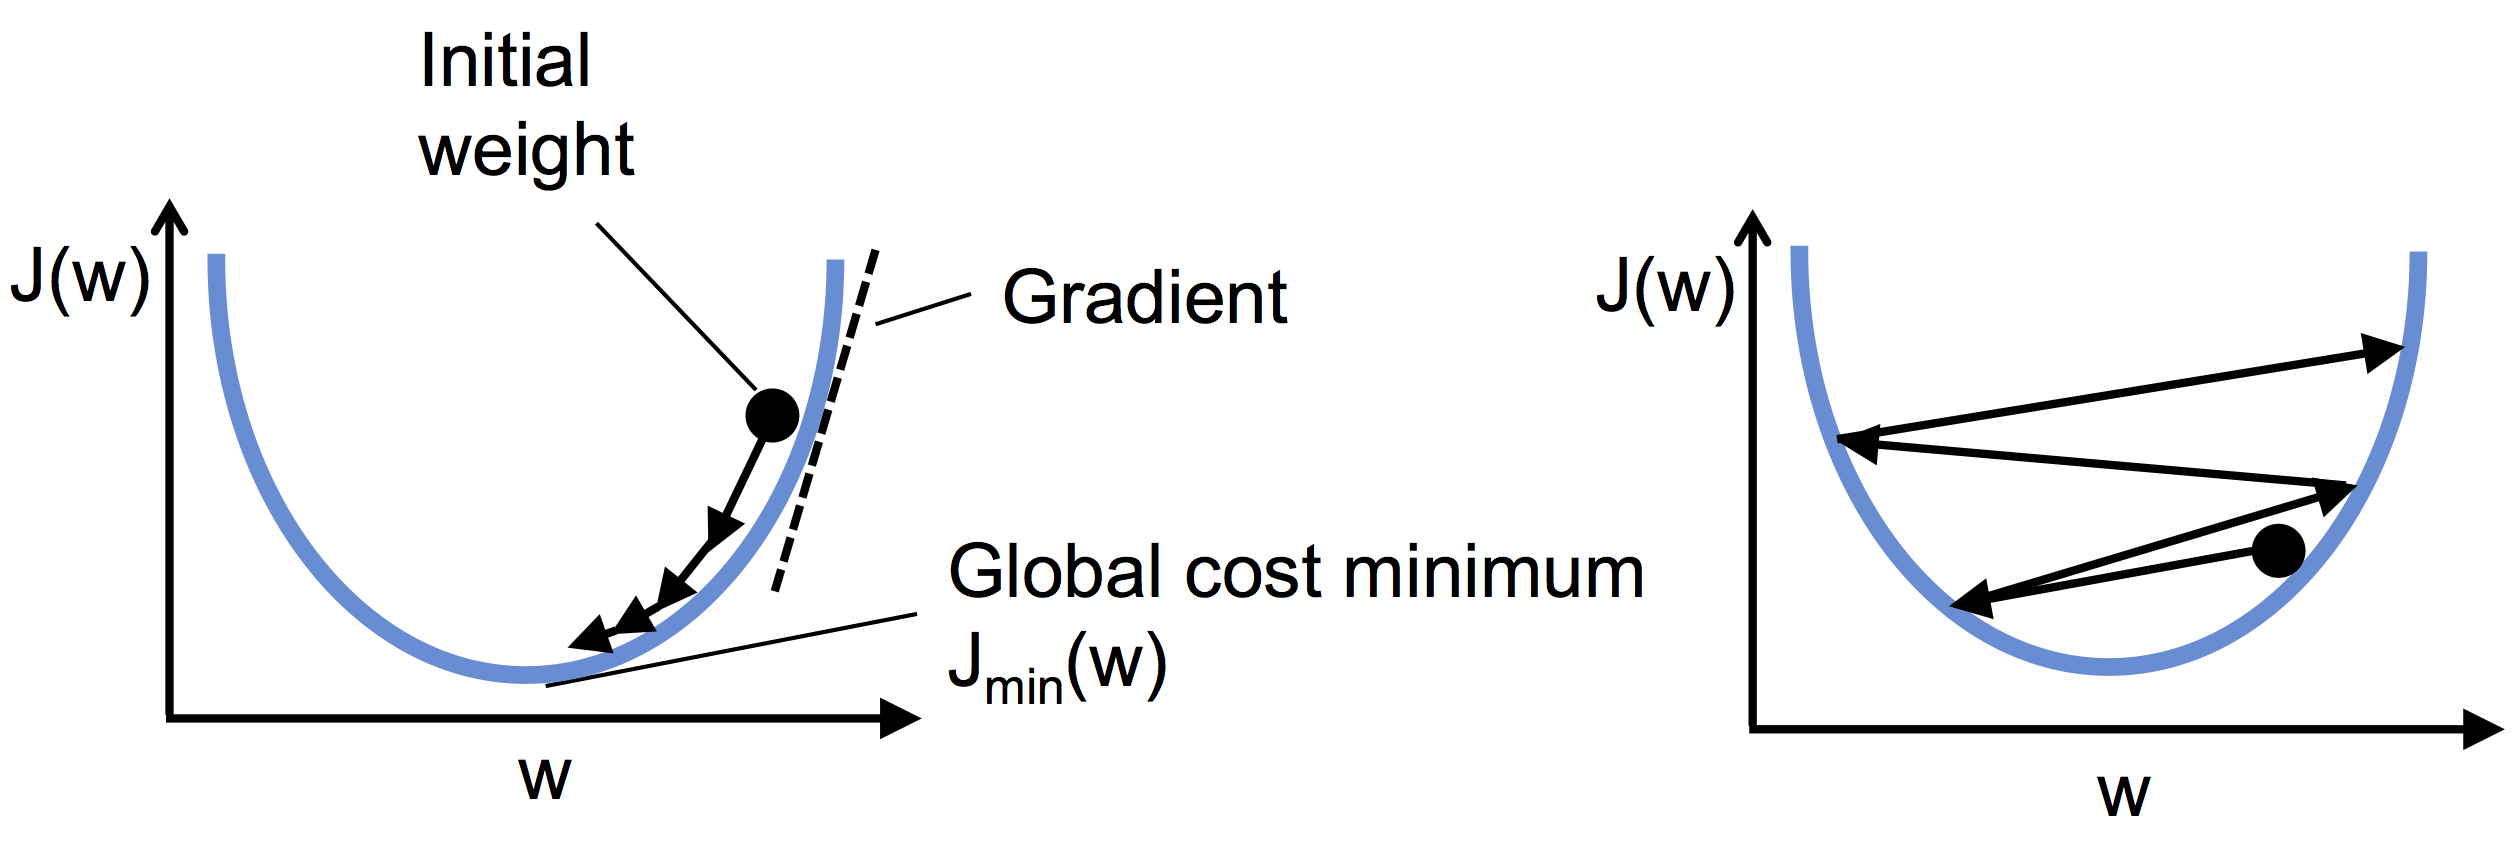

In [ ]:
Image(filename='effect_of_eta.png', width=600)

The left subfigure shows that if choose the "right learning rate", the cost decreases gradually, moving in the direction of the global minimum.

The right subfigure shows what happens if we choose a learning rate that is too large - we miss the global minimum.

### Linear Regression (Stochastic Gradient Descent) 

<span style="color:chocolate"> *Update weights:*</span>

$w_{j} := w_{j} + \Delta w_{j}, \forall j \in {1,...,m}$

$\Delta w_{j} = \eta (y\_actual_{i} - \phi(z_{i}))\cdot x_{i,j}, \forall j \in {1,...,m}, \forall i \in {1,...,n}$

`` Note on Stochastic Gradient Descent``:

The weights are updated using **one training example at a time** (no summation operator in the equation $\Delta w_{j}$)


As a result, the SGD typically reaches convergence much faster than BGD because of the more frequent weight updates.

In [ ]:
# Step 1: initalize hyperparameters
eta = 0.001
n_iter = 10
random_state = 1

# Step 2: initalize weights (to small random numbers)
rgen = np.random.RandomState(random_state)
w_ = rgen.normal(loc=0.0, scale=0.01, size=1 + temp_shape_X_train_std)

# Step 3: initialize cost lists
cost_ = []


# Step 4: compute net input, linear activation function, update weights, track cost
def fit(X, y):
    for iter_ in range(n_iter):
        cost = []
        # shuffle the data after each iteration to avoid repetitive cycles when we optimize the cost function
        shuffle = np.random.permutation(np.arange(X.shape[0]))
        X, y = X[shuffle], y[shuffle]
        
        
        # compute the net input function
        net_input = np.dot(X, w_[1:]) + w_[0]

        # compute the linear activation function; this gives us y_pred
        temp_y_pred = net_input
        
        # iterate through all i in X,y
        for idx, (xi, y_actual) in enumerate(zip(X, y)):
            # compute error
            errors = (y_actual - temp_y_pred[idx])
            

            # update weights (notice how weights are updated using one training example at a time!)
            w_[1:] += eta * xi.dot(errors)
            w_[0] += eta * errors

            # compute cost (we find weights by minimizing costs; in the Linear model the cost is SSE/2)
            cost.append(errors**2/2.0)
            
        avg_cost = sum(cost)/len(y)
        cost_.append(avg_cost)
    return cost_

# Step 5: compute the threshold (linear) function; it's just the net input function in the linear model
def predict(X):
    net_input = np.dot(X, w_[1:]) + w_[0]
    # threshold function
    y_pred = net_input
    
    return y_pred

Model fit and prediction

CPU times: user 28.1 ms, sys: 52 µs, total: 28.2 ms
Wall time: 30.7 ms


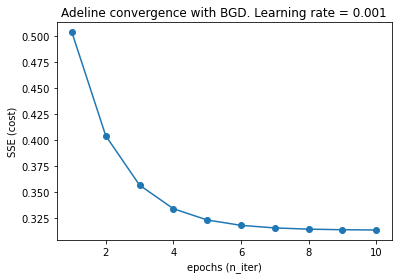

In [ ]:
%time cost_ = fit(temp_X_train_std, y_train_std)
y_train_std_pred = predict(temp_X_train_std)

# plot cost
plt.plot((range(1, len(cost_) + 1)), cost_, marker='o');
plt.xlabel('epochs (n_iter)');
plt.ylabel('SSE (cost)'); # number of times y_actual != y_pred

plt.title('Adeline convergence with BGD. Learning rate = ' + str(eta));

Evaluation

In [ ]:
print('MSE (train):', mean_squared_error(y_train_std, y_train_std_pred))

MSE (train): 0.6264470341997266


``The regression line``

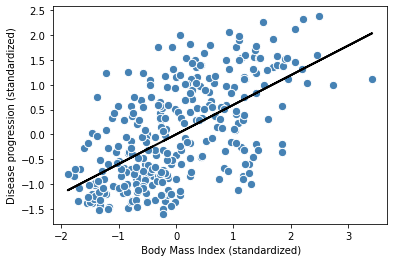

In [ ]:

plt.scatter(temp_X_train_std, y_train_std, c='steelblue', edgecolor='white', s=70)
plt.plot(temp_X_train_std, y_train_std_pred, color='black', lw=2)    

plt.xlabel(' Body Mass Index (standardized)')
plt.ylabel('Disease progression (standardized)')
plt.show()

As you can see, the linear regression line reflects the general trend that diabetes progression tends to increase with the BMI. This observation makes sense but the data also tells us that BMI does not explain disease progression very well in many cases.

**MSE on the test data...** <br>
How would you improve the MSE of the model? Implement your idea.


In [ ]:
y_test_std_pred = predict(temp_X_test_std)

print('MSE (test):', mean_squared_error(y_test_std, y_test_std_pred))

MSE (test): 0.6796136670963322
